# Random Forest Regression
Official documentation link [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

## Importing the libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Paper 13/paper13.csv')
df.head()

,Biomass type,Reactor/feeding,VS (%),pH,OLR (g VS/l.d),HRT (d),T (°C),Reactor Volume (m³),Cumulated biogas volume (L/(g VS))
0,0,0,10.00,7.62,0.6270,19.2,55,0.0500,0.0668
1,0,2,15.30,8.00,3.1702,47.0,37,0.0473,0.6765
2,0,0,4.78,7.25,1.2400,15.0,37,0.0450,0.8227
3,0,0,4.78,7.25,1.7600,15.0,37,0.0450,0.6219
4,0,2,6.36,7.30,3.2000,25.0,35,0.0400,0.5755


## Dropping columns 
Since EDA points out that 
1. Biomass Type,   
2. OLR   
3. Reactor Volume   
are not strongly corelated with the output, they can be dropped.  

In [40]:
# df.drop(columns=['Reactor Volume (m³)'], inplace=True)
# df.head()

## Outlier Detection and Removal
### 1. Temperature

In [41]:
# percentile25 = df['T (°C)'].quantile(0.25)
# percentile75 = df['T (°C)'].quantile(0.75)

# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

# print(upper_limit)
# print(lower_limit)

# # Removing outliers
# df = df[df['T (°C)'] <= 50]

# df.shape

## 2. VS%

In [42]:
percentile25 = df['VS (%)'].quantile(0.25)
percentile75 = df['VS (%)'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(upper_limit)
print(lower_limit)

# Removing outliers
df = df[df['VS (%)'] <= upper_limit]

df.shape

25.784999999999997
-6.7349999999999985


(106, 9)

## 3. HRT


In [43]:
# percentile25 = df['HRT (d)'].quantile(0.25)
# percentile75 = df['HRT (d)'].quantile(0.75)

# iqr = percentile75 - percentile25
# upper_limit = percentile75 + 1.5 * iqr
# lower_limit = percentile25 - 1.5 * iqr

# print(upper_limit)
# print(lower_limit)

# Removing outliers
# new_df = df[df['VS (%)'] > upper_limit]

# new_df.shape
# These outliers were removed as part of the VS% outliers

## 4. OLR

In [44]:
# Using the percentile method of outlier removal

upper_limit = df['OLR (g VS/l.d)'].quantile(0.99)
lower_limit = df['OLR (g VS/l.d)'].quantile(0.01)

print(upper_limit)
print(lower_limit)

# Removing outliers
df = df[df['OLR (g VS/l.d)'] <= upper_limit]

df.shape
df.head()

16.002800000000008
0.2


,Biomass type,Reactor/feeding,VS (%),pH,OLR (g VS/l.d),HRT (d),T (°C),Reactor Volume (m³),Cumulated biogas volume (L/(g VS))
0,0,0,10.00,7.62,0.6270,19.2,55,0.0500,0.0668
1,0,2,15.30,8.00,3.1702,47.0,37,0.0473,0.6765
2,0,0,4.78,7.25,1.2400,15.0,37,0.0450,0.8227
3,0,0,4.78,7.25,1.7600,15.0,37,0.0450,0.6219
4,0,2,6.36,7.30,3.2000,25.0,35,0.0400,0.5755


## Splitting the data into Test and training data

In [45]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Cumulated biogas volume (L/(g VS))'])
y = df['Cumulated biogas volume (L/(g VS))']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Pipeline information

(Since this data does not have missing values, not imputation is required.)

The following transformers will be applied in the pipeline.

Step 1: OneHotEncoding the categorical columns. 

Step 2: Scaling using StandardScaler

Step 3: Training

(We could have added feature selection before training as well)

Note: After OneHot Encoding, the number of columns becomes:  
5 (for reactor/feeding)  
\+ 4

= 9




In [46]:
# 1. One Hot Encoding
trf0 = ColumnTransformer(transformers = [
    ('ohe0', OneHotEncoder(), ['Reactor/feeding', 'Biomass type'])
], remainder='passthrough')

In [47]:
# 2. Scaling
#  Scaling only the temperature column
trf2 = ColumnTransformer([
    ('scale', StandardScaler(), slice(2,10)) # No OHE, 2 categorical vairables
    # ('scale', StandardScaler(), slice(1,10)) # No OHE, 1 categorical vairable
    # ('scale', StandardScaler(), slice(8,15)) # With OHE, 2 categorical vairable
], remainder = 'passthrough')

In [48]:
# 3. Transformation

# The slicing column numbers have to be changed since after the first transformation, the columns are reordered.
trf3 = ColumnTransformer([
    ('transform', PowerTransformer(), slice(2,10))
], remainder='passthrough') 

In [49]:
# 3. Training
trf4 = RandomForestRegressor(random_state = 0, n_estimators= 500, max_features='sqrt', max_depth=32, criterion='squared_error')

## Creating the pipeline

In [50]:
pipe = Pipeline([
    # ('ohe0', trf0),
    ('scaling', trf2),
    # ('transform', trf3),
    ('rf', trf4),
])

## Training and predicting using the pipeline

Here we are using default parameters

In [51]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')
# Show the steps involved in the pipeline
pipe.named_steps

# train and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2_score(y_test, y_pred)

# Visualize 
# X_trans = pipe.fit_transform(X_train)
# X_pd = pd.DataFrame(X_trans)
# X_pd.head()

0.8951557115010592

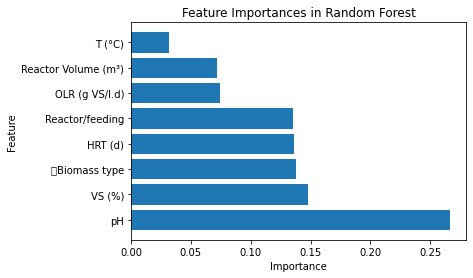

In [55]:
# Get the feature importance scores
importances = trf4.feature_importances_

importances.shape
# Create a dataframe of feature importances
feature_importances = pd.DataFrame({"feature": ["	Biomass type",	"Reactor/feeding",	"VS (%)",	"pH",	"OLR (g VS/l.d)",	"HRT (d)",	"T (°C)",	"Reactor Volume (m³)"], 
                                    "importance": importances})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Plot the feature importances
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest")
plt.show()

## GridSearch using the pipeline
1. n_estimators: Number of trees in the forest. Defaults to 100.
2. criterion: Function to measure the quality of a split.
3. max_featues: Maximum number of features to be considered when looking for a split.
4. max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


In [15]:
# gridsearchcv
params = {
    'rf__n_estimators':[ 50, 100, 500],
    'rf__criterion':['squared_error', 'absolute_error'],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__max_depth': [ 8,  32, None],
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=10, scoring='r2')
grid.fit(X, y)


KeyboardInterrupt: ignored

# GridSearchCV results


In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

# Important Results:

### a. Nothing dropped, no scaling
1. r2_score = 0.6391
2. cv_score =  0.6188
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 1000}`

### b. Nothing dropped, WITH scaling on non categorical data
1. r2_score = 0.6329
2. cv_score =  0.6179
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_depth': 32,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500}`

### c. Biomass type, OLR and reactor volume have been dropped

1. r2_score = 0.6526
2. cv_score =  0.4617
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_depth': 32,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500}`

### d. Biomass type and reactor volume have been dropped

1. r2_score = **0.7660**
2. cv_score =  0.6130
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_depth': 32,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 50}`

### e. Biomass type has been dropped

1. r2_score = **0.7807**
2. cv_score =  0.5544
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_depth': 32,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500}`


### f. Reactor volume has been dropped

1. r2_score = **0.7824**
2. cv_score =  0.6149
3. best params = `{'rf__criterion': 'squared_error',
 'rf__max_depth': 32,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 50}`

## BEST Results (without outlier removal):
Reactor Volume dropped.   
r2_score = **0.7824**   
cv_score =  0.6149

## Outlier removal

1. Temperature: The results were significantly worse.  
  r2_score = 0.5216  
  cv_score = 0.5484  

2. VS% : The CV score improved.  
  r2_score = 0.7479   
  cv_score = **0.6201**  

3. OLR and VS%:  
  r2_score = **0.8940**  
  cv_score = 0.6106

4. OLR and VS% (Transform instead of Scaling):  
  r2_score = **0.8980**  
  cv_score = 0.6089

**Best results WITH outlier removal**  
  r2_score = **0.8940**   
  cv_score = 0.6106


Note:  
Using OHE for categorical values decreased the scores slightly.